In [13]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
np.random.seed(7) # fix random seed for reproducibility

from keras.models import Sequential
from keras.layers import Dense, Dropout

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

import pandas as pd


# Section 2

### Build a classifier which has the aim of predicting the categorical variable in the data set found in section 1.

###  Q1) You are free to choose any Machine Learning algorithm to produce a classifier

Below I use a shallow and wide neural network to predict Variable 11.

It achieves a prediction accuracy of ~86%.

From the correlation matrix in Section 1, there is a clear non-linear structure to the data. With category 'g' looking like a 'smaller' variant of 'h'. 

I assumed that a neural net would be efficient at handling the strong nonlinear relationships.

After experimenting with various sequential networks, different data pre-processing and batch sizes, I found a simple 2-layer network [rectifier, sigmoid] gave the best results.

I discuss other possible avenues to improve the model below.


## Read in the data

In [2]:
df = pd.read_csv('MM.data', header=None)

In [3]:
# add column names
newcols = {}
for col in df.columns:
    newcols[col] = 'V{}'.format(col+1)
df.rename(index=str, columns=newcols, inplace=True)    

In [4]:
# convert categorical column to number
df['y'] = 0
df.loc[df.V11=='h', 'y'] = 1
df = df.drop('V11', axis=1)

# random shuffle data
df = df.sample(frac=1, random_state=2).reset_index(drop=True)

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,y
0,34.6908,11.2351,2.5004,0.3791,0.1975,-35.4735,21.2479,-7.7418,10.6120,152.891,0
1,20.2065,9.0614,2.3424,0.6273,0.3886,22.1011,12.9607,3.5576,33.3900,215.372,0
2,79.2821,27.9011,3.1173,0.2756,0.1416,-17.0897,-29.9275,-12.9796,5.1600,324.141,0
3,23.3897,10.0375,2.6217,0.5830,0.3214,26.0773,20.5688,7.5347,19.8253,132.785,0
4,33.7801,14.7812,2.4378,0.4526,0.2646,-34.2524,-19.3872,-10.7488,66.7550,144.690,1


In [5]:
# write data to matrix
X = df.as_matrix(df.columns[:-1])
Y = df.as_matrix(df.columns[-1:]).flatten()

### Q2) Use any data transformations you deem appropriate (comment why if you use any)


I tried several different out of the box pre-processing techniques to bring the scale of the inputs down and to center them around 0.

sklearn's `StandardScaler` had the largest impact on accuracy (~4% gain)

### Q3) Use any target metric you see fit (comment why)

Each model optimised the binary cross entropy loss - which is standard for binary categorisation.

And the models were compared for predictive accuracy - as that is the aim of the model.


#### function to plot model loss and accuracy history

In [6]:
def plot_history(history):
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=False, sharey=False)
    
    # summarize history for accuracy
    ax[0].plot(history.history['acc'])
    ax[0].plot(history.history['val_acc'])
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    #ax[0, 0].legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    
    plt.legend(['train', 'test'], loc='center right')
    
    sns.despine()
    plt.show()
    


### Run the model

Here we use 10 fold cross validation

In [7]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cvscores = []
for train, test in kfold.split(X, Y):
    
    # apply standard scaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X[train])
    X_test = scaler.transform(X[test])
    
    # create model
    model = Sequential()
    model.add(Dense(140, input_dim=10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Fit the model
    model.fit(X_train, Y[train], epochs=50, batch_size=10, verbose=0)    
    
    # evaluate the model
    scores = model.evaluate(X_test, Y[test], verbose=0)
    print('{}: {:.2f}%'.format(model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)   


acc: 87.86%
acc: 88.33%
acc: 87.22%
acc: 87.22%
acc: 88.07%
acc: 88.49%
acc: 86.54%
acc: 88.22%
acc: 86.85%
acc: 86.64%


### Q4) Quote the performance of your classifier and produce an estimate of what the classifiers out of sample error would be. 

In [8]:
print('Performance of the classifier\n')
print('Predicted accuracy : {:.2f}% (+/- {:.2f})'.format(np.mean(cvscores), np.std(cvscores)))
cverrors = 100 - np.array(cvscores)
print('Out of sample error: {:.2f}%'.format(np.mean(cverrors)))

Performance of the classifier

Predicted accuracy : 87.54% (+/- 0.70)
Out of sample error: 12.46%


### Rerun the model once for training history example

In [9]:
# apply standard scaler
scaler = StandardScaler()
scaled = scaler.fit_transform(X)

# create model
model = Sequential()
model.add(Dense(140, input_dim=10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model.fit(scaled, Y, validation_split=0.5, epochs=50, batch_size=20, verbose=0)

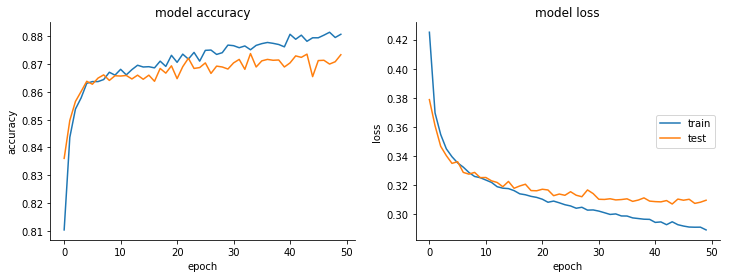

In [10]:
plot_history(history)

### Q4) contd. If you’re taking short cuts outline what a solution with more time would entail.

I have not determined if there are overlapping records between the two categories. Which would put a hard limit on the accuracy of the model.

More time should be spent investigating possible transformations of the features. There is a very clear structure to the data. It looks like the data may represent slices from the surface of a 3d object. In which case a set of non-linear transformations for each feature could help. Or if the geometry of the data cannot be identified, a form of feature extraction such as an Isomap could improve accuracy.

There would be more scope for experimentation with rescaling and a more systematic effort to tune the alogorithm.

Convolution layers might help if this is a shape recognition problem.


### Q5) Produce a ROC curve for your predictions

In [11]:
# get the predictions
model_pred = model.predict(X_test)

# get false and true positive rates
fpr, tpr, _ = roc_curve(Y[test], model_pred)

# calculate area under the curve
roc_auc = auc(fpr, tpr)

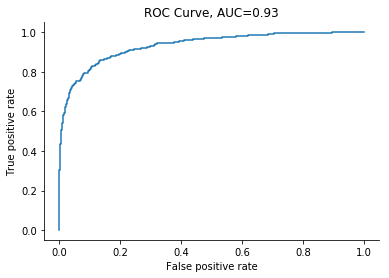

In [14]:
# plot the ROC curve

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve, AUC={:.2f}'.format(roc_auc))

sns.despine()
plt.show()